In [1]:
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os


In [2]:
def eakf_step_multi_obs(params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_obs=1):
    prior_mean_ct = obs_ens_time.mean(-1, keepdims=True) # Average over ensemble member
    prior_var_ct  = obs_ens_time.var(-1, keepdims=True)  # Compute variance over ensemble members

    idx_degenerate = np.where(prior_mean_ct==0)[0]
    prior_var_ct[idx_degenerate] =  1e-3

    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = np.full((len(dict_params_range), num_obs), np.nan)
    dx = np.full((len(dict_params_range) , obs_ens_time.shape[-1], num_obs), np.nan)

    for idx_obs in range(num_obs):
        for idx_p, p in enumerate(dict_params_range.keys()):
            A = np.cov(params_prior[idx_p,:], obs_ens_time[idx_obs,:])
            rr[idx_p, idx_obs] =  A[1,0] / prior_var_ct[idx_obs]
        dx[:, :, idx_obs] =  np.dot( np.expand_dims(rr[:, idx_obs],-1), np.expand_dims(dy[idx_obs,:], 0) )

    mean_rr = rr.mean(-1) # Average over observation space
    mean_dy = dy.mean(0)  # Average over observation space
    mean_dx = dx.mean(-1)

    param_post = params_prior + mean_dx
    obs_post   = obs_ens_time + mean_dy

    return param_post, obs_post

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def compute_sen_oev(obs_vec, var_obs=0.2):
    return 1 + (var_obs*obs_vec)**2

def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )


def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

def geometric_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(num_iteration_if)
    return alphas**2

def hyperbolic_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = 1/(1+cooling_factor*np.arange(num_iteration_if))
    return alphas


def cooling(num_iteration_if, type_cool="geometric", cooling_factor=0.9):
    if type_cool=="geometric":
        return geometric_cooling(num_iteration_if, cooling_factor=cooling_factor)
    elif type_cool=="hyperbolic":
        return hyperbolic_cooling(num_iteration_if, cooling_factor=cooling_factor)


def random_walk_perturbation(param, param_std, num_params, num_ensembles):
    return param + param_std * np.random.normal(size=(num_params, num_ensembles))


def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)


In [3]:
from tqdm import tqdm
import seaborn as sns
import arviz as az
plt.rc('font', size=15, family='sans-serif', serif='Arial')          # controls default text sizes

mean_prior               = [-4, 4]
std_prior                = [0, 2]

param_prior_dict         = {}
param_prior_dict["mean"] = mean_prior
param_prior_dict["std"]  = std_prior



prior_range = {"low": -3, "high":4.5}
num_samples = 100000

observation  = 2.0
oev          = compute_sen_oev(observation)
normal_dist  = get_truncated_normal(mean=observation, sd=np.sqrt(oev), low=prior_range["low"], upp=prior_range["high"])
x_eval       = np.linspace(prior_range["low"], prior_range["high"], num=1000)
pdf_dist     = normal_dist.pdf(x=x_eval)
samples_dist = normal_dist.rvs(num_samples)

obs_df        = pd.DataFrame(columns=["obs", "oev"])
obs_df["obs"] = [observation]
obs_df["oev"] = [oev]

if2_settings                     = {}
if2_settings["num_params"]       = len(param_prior_dict)
if2_settings["num_observations"] = 1
if2_settings["lambda_inf"]       = 1.01
if2_settings["num_iters_mif"]    = 10
if2_settings["alpha_mif"]        = 0.9  # Variance shrinking factor
if2_settings["type_cooling"]     = "geometric"
if2_settings["num_ensembles"]    = 300

num_steps = 1


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12215/3523536828.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )
100%|██████████| 10/10 [00:00<00:00, 30.05it/s]


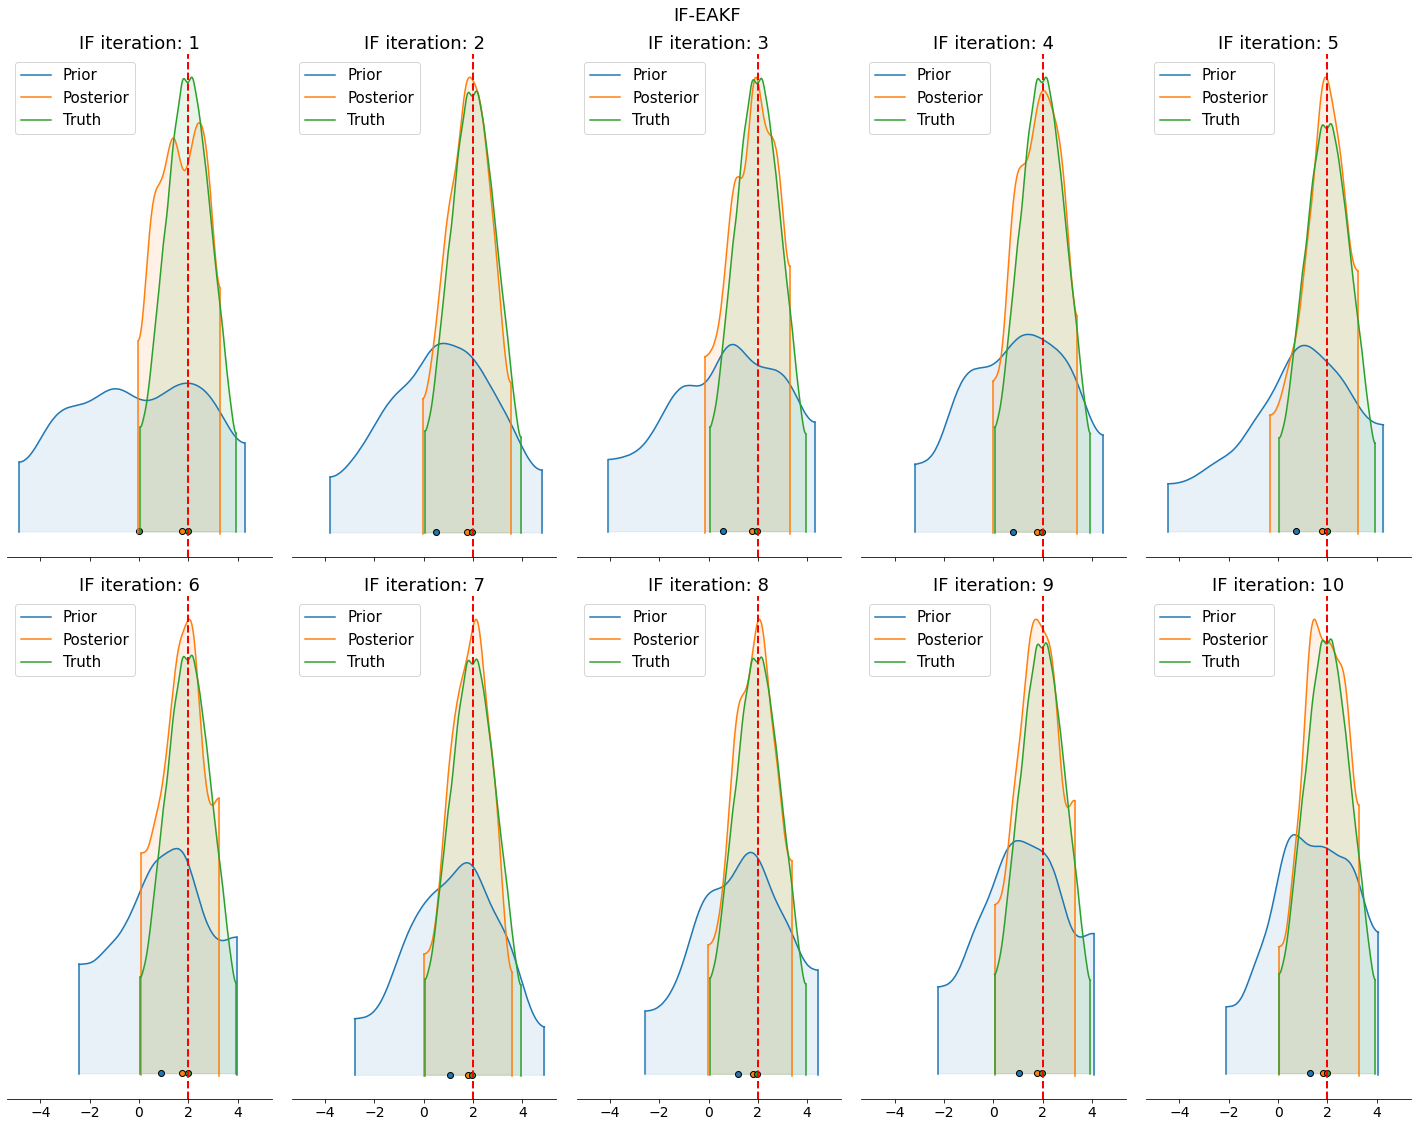

In [4]:

perturb_time = False
# Perturbation is proportional to the prior range of search.

cooling_factor   = cooling(if2_settings["num_iters_mif"], type_cool=if2_settings["type_cooling"], cooling_factor=if2_settings["alpha_mif"])

param_range      = np.array([v for k, v in param_prior_dict.items()])
std_param        = param_range[:,1] - param_range[:,0]
SIG              = std_param ** 2 / 4; #  initial covariance of parameters

perturbation     = np.array([std_param % list(np.round(std_param)+0.1)]).T


param_mean_iter  = np.full((if2_settings["num_params"],       if2_settings["num_iters_mif"]+1), np.nan)                                         # Array to store posterior parameters in iterations.
para_post_all    = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array to store posterior parameters.
obs_post_all     = np.full((if2_settings["num_observations"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array for store posterior observations
obs_prior_all     = np.full((if2_settings["num_observations"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array for store posterior observations

param_iter       = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], if2_settings["num_iters_mif"]), np.nan)
para_prior_all   = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan)
p_priors_all     = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], if2_settings["num_iters_mif"]), np.nan)

def model(means, variances):
    return get_truncated_normal(mean=means, sd=variances, low=-10, upp=10).rvs()


for n in tqdm(range(if2_settings["num_iters_mif"])):
    if n==0: # Initial IF iteration

        p_prior               = sample_params_uniform(param_prior_dict, num_ensembles=if2_settings["num_ensembles"])
        param_mean_iter[:, n] = np.mean(p_prior, -1)
        p_priors_all[:,:,n]   = p_prior

    else:
        params_mean           = param_mean_iter[:,n]
        params_var            = SIG * cooling_factor[n]
        p_prior               = sample_params_normal(param_prior_dict, params_mean, params_var, num_ensembles=if2_settings["num_ensembles"])
        p_priors_all[:,:,n]   = p_prior



    idx_date_update   = 0

    # Init observation arrays.
    pos_t       = np.zeros((if2_settings["num_ensembles"]))

    if perturb_time:
        # Transform parameters for perturbation
        std_params = perturbation*cooling_factor[n]
        p_prior    = random_walk_perturbation(p_prior, std_params, if2_settings["num_params"], if2_settings["num_ensembles"])

    # Inflate parameters
    p_prior = inflate_ensembles(p_prior, inflation_value=if2_settings["lambda_inf"], num_ensembles=if2_settings["num_ensembles"])
    p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=if2_settings["num_ensembles"])


    oev_confirmed_time   = obs_df["oev"].values
    confirmed_time       = obs_df["obs"].values

    param_post           = p_prior.copy()

    obs_sim = model(p_prior[0,:], p_prior[1,:])
    obs_sim = np.expand_dims(obs_sim, 0)

    para_prior_all[:,:,0,n]  = param_post
    obs_prior_all[:,:,0,n]    = obs_sim

    param_post, obs_post = eakf_step_multi_obs(param_post, obs_sim, np.expand_dims(confirmed_time, -1),  np.expand_dims(oev_confirmed_time, -1), param_prior_dict, if2_settings["num_observations"])
    param_post           = checkbound_params(param_prior_dict, param_post, num_ensembles=if2_settings["num_ensembles"])

    obs_post_all[:,:,0,n]    = obs_post
    para_post_all[:,:,0,n]  = param_post

    param_mean_iter[:,n+1] = param_post.mean(-1)

obs_post_all = np.squeeze(obs_post_all)
obs_prior_all = np.squeeze(obs_prior_all)

para_post_all = np.squeeze(para_post_all)
para_prior_all = np.squeeze(para_prior_all)

fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharex=True)

for idx_ax, ax in enumerate(axes.flatten()):

    prior_obs = obs_prior_all[:, idx_ax]
    post_obs  = obs_post_all[:, idx_ax]

    az.plot_density(ax=ax, data=[prior_obs, post_obs, samples_dist], data_labels=["Prior", "Posterior", "Truth"], shade=0.1)
    ax.axvline(x=observation, color="red", ls="--", lw=2)
    ax.set_title("IF iteration: {}".format(idx_ax+1))
    ax.legend(loc="upper left")
axes[0, 0].legend(loc="upper left")
fig.suptitle("IF-EAKF")
plt.tight_layout()
fig.savefig("IF_EAKF.png", dpi=300, transparent=True)


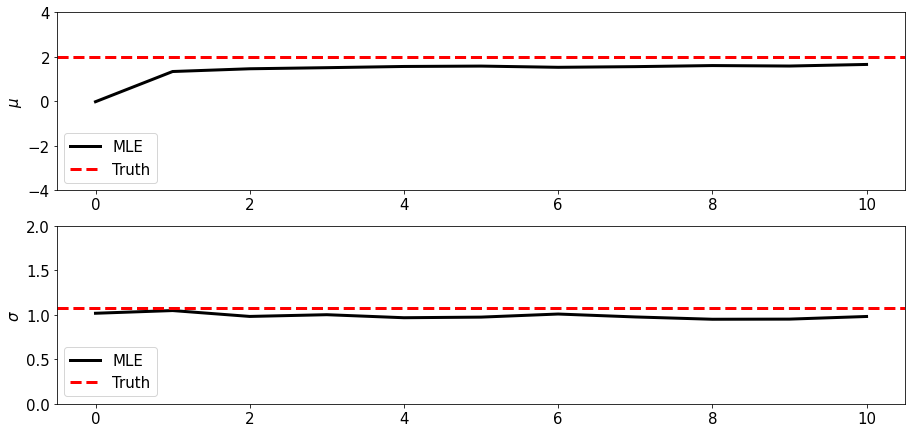

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(15.2, 7.2))

ax[0].plot(range(if2_settings["num_iters_mif"]+1), param_mean_iter[0,:], color="k", lw=3, label="MLE"); ax[0].axhline(y=obs_df["obs"].values, color="red", lw=3, ls="--", label="Truth")
ax[1].plot(range(if2_settings["num_iters_mif"]+1), param_mean_iter[1,:], color="k", lw=3, label="MLE"); ax[1].axhline(y=oev**(1/2), color="red", lw=3, ls="--", label="Truth")

ax[0].set_ylim([param_prior_dict["mean"][0], param_prior_dict["mean"][1]])
ax[1].set_ylim([param_prior_dict["std"][0], param_prior_dict["std"][1]])

ax[0].legend(loc="lower left")
ax[1].legend(loc="lower left")

ax[0].set_ylabel(r"$\mu$")
ax[1].set_ylabel(r"$\sigma$")

fig.savefig("IF1_EAKF_convergence_plots.png", dpi=300, transparent=True)


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12215/3523536828.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )
100%|██████████| 10/10 [00:00<00:00, 21.80it/s]


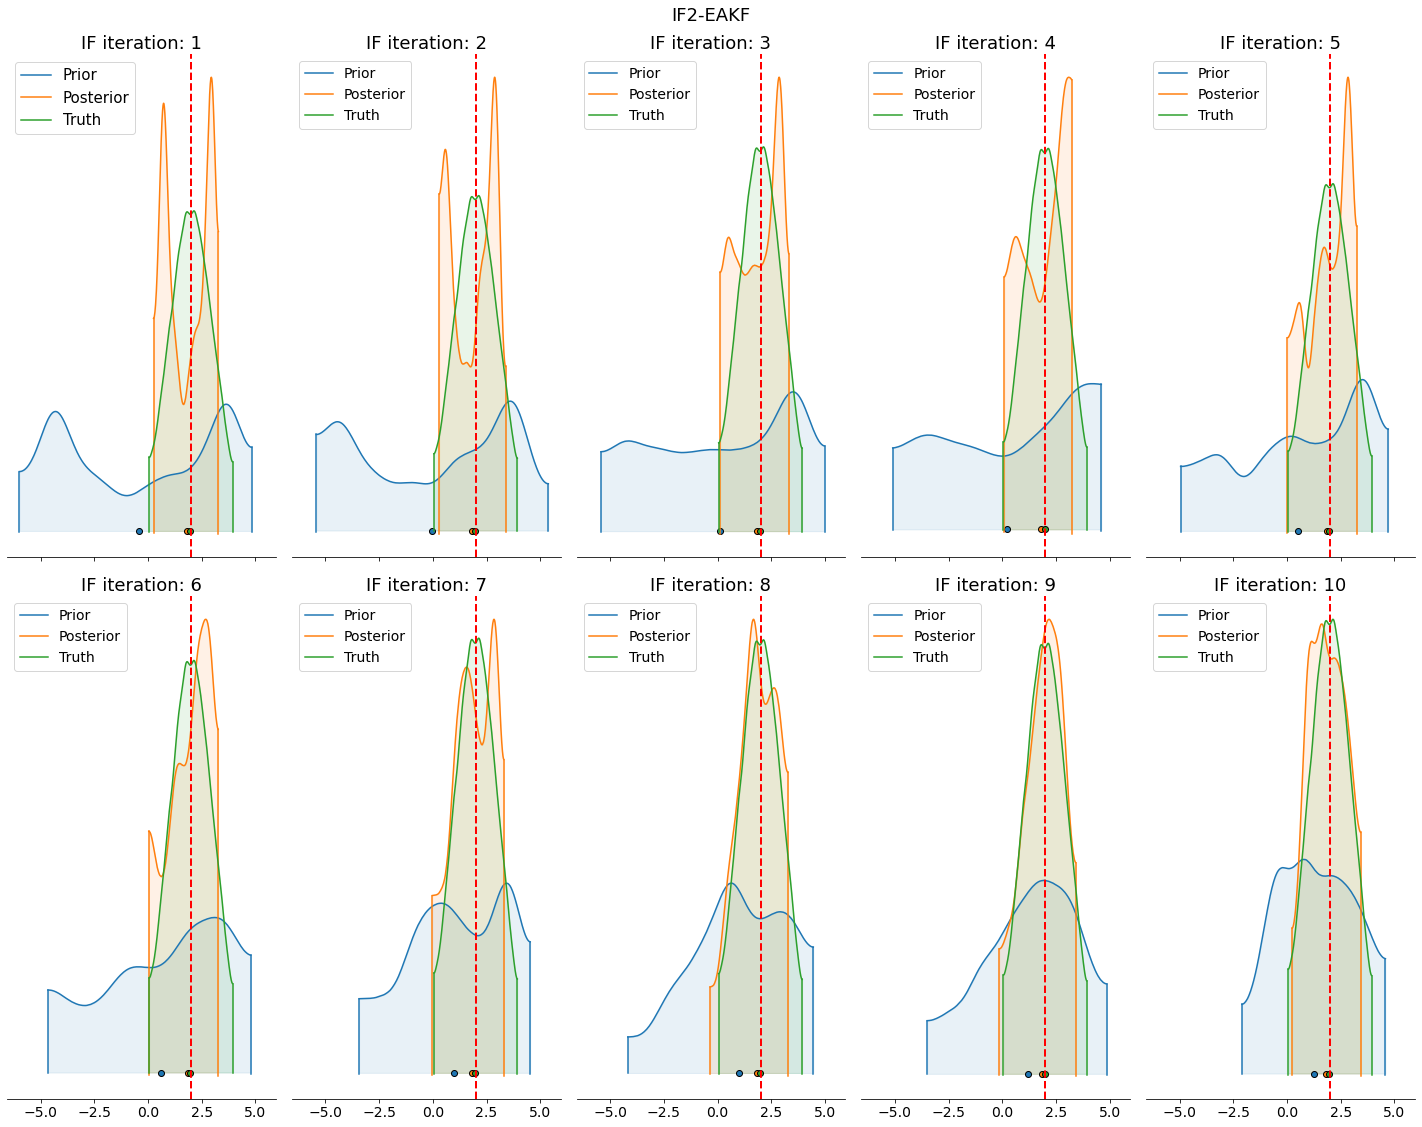

In [6]:

perturb_time = True
# Perturbation is proportional to the prior range of search.

cooling_factor   = cooling(if2_settings["num_iters_mif"], type_cool=if2_settings["type_cooling"], cooling_factor=if2_settings["alpha_mif"])

param_range      = np.array([v for k, v in param_prior_dict.items()])
std_param        = param_range[:,1] - param_range[:,0]
SIG              = std_param ** 2 / 4; #  initial covariance of parameters

perturbation     = np.array([std_param % list(np.round(std_param)+0.1)]).T


param_mean_iter  = np.full((if2_settings["num_params"],       if2_settings["num_iters_mif"]+1), np.nan)                                         # Array to store posterior parameters in iterations.
para_post_all    = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array to store posterior parameters.
obs_post_all     = np.full((if2_settings["num_observations"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array for store posterior observations
obs_prior_all     = np.full((if2_settings["num_observations"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array for store posterior observations

param_iter       = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], if2_settings["num_iters_mif"]), np.nan)
para_prior_all   = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan)
p_priors_all     = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], if2_settings["num_iters_mif"]), np.nan)

def model(means, variances):
    return get_truncated_normal(mean=means, sd=variances, low=-10, upp=10).rvs()


for n in tqdm(range(if2_settings["num_iters_mif"])):
    if n==0: # Initial IF iteration

        p_prior               = sample_params_uniform(param_prior_dict, num_ensembles=if2_settings["num_ensembles"])
        param_mean_iter[:, n] = np.mean(p_prior, -1)
        p_priors_all[:,:,n]   = p_prior

    else:
        params_mean           = param_mean_iter[:,n]
        params_var            = SIG * cooling_factor[n]
        p_prior               = sample_params_normal(param_prior_dict, params_mean, params_var, num_ensembles=if2_settings["num_ensembles"])
        p_priors_all[:,:,n]   = p_prior



    idx_date_update   = 0

    # Init observation arrays.
    pos_t       = np.zeros((if2_settings["num_ensembles"]))

    if perturb_time:
        # Transform parameters for perturbation
        std_params = perturbation*cooling_factor[n]
        p_prior    = random_walk_perturbation(p_prior, std_params, if2_settings["num_params"], if2_settings["num_ensembles"])

    # Inflate parameters
    p_prior = inflate_ensembles(p_prior, inflation_value=if2_settings["lambda_inf"], num_ensembles=if2_settings["num_ensembles"])
    p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=if2_settings["num_ensembles"])


    oev_confirmed_time   = obs_df["oev"].values
    confirmed_time       = obs_df["obs"].values

    param_post           = p_prior.copy()

    obs_sim = model(p_prior[0,:], p_prior[1,:])
    obs_sim = np.expand_dims(obs_sim, 0)

    para_prior_all[:,:,0,n]  = param_post
    obs_prior_all[:,:,0,n]    = obs_sim

    param_post, obs_post = eakf_step_multi_obs(param_post, obs_sim, np.expand_dims(confirmed_time, -1),  np.expand_dims(oev_confirmed_time, -1), param_prior_dict, if2_settings["num_observations"])
    param_post           = checkbound_params(param_prior_dict, param_post, num_ensembles=if2_settings["num_ensembles"])

    obs_post_all[:,:,0,n]    = obs_post
    para_post_all[:,:,0,n]  = param_post

    param_mean_iter[:,n+1] = param_post.mean(-1)

obs_post_all = np.squeeze(obs_post_all)
obs_prior_all = np.squeeze(obs_prior_all)

para_post_all = np.squeeze(para_post_all)
para_prior_all = np.squeeze(para_prior_all)

fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharex=True)

for idx_ax, ax in enumerate(axes.flatten()):

    prior_obs = obs_prior_all[:, idx_ax]
    post_obs  = obs_post_all[:, idx_ax]

    az.plot_density(ax=ax, data=[prior_obs, post_obs, samples_dist], data_labels=["Prior", "Posterior", "Truth"], shade=0.1)
    ax.axvline(x=observation, color="red", ls="--", lw=2)
    ax.set_title("IF iteration: {}".format(idx_ax+1))
axes[0, 0].legend(loc="upper left")
fig.suptitle("IF2-EAKF")
plt.tight_layout()
fig.savefig("IF2_EAKF.png", dpi=300, transparent=True)


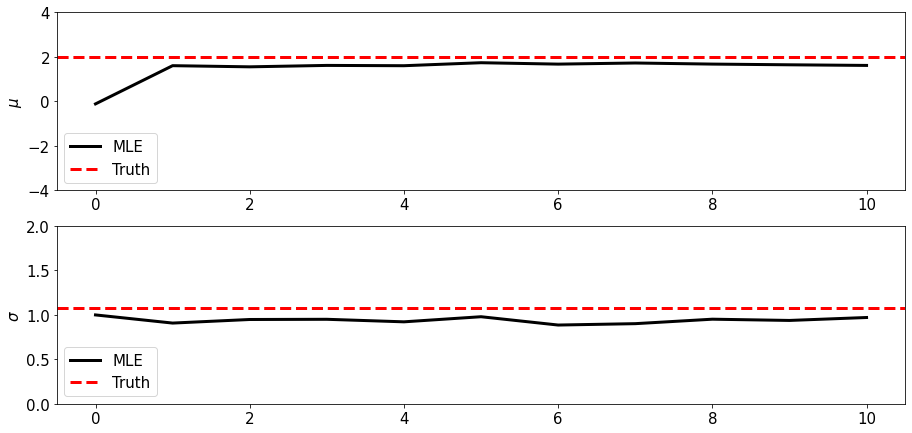

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15.2, 7.2))

ax[0].plot(range(if2_settings["num_iters_mif"]+1), param_mean_iter[0,:], color="k", lw=3, label="MLE"); ax[0].axhline(y=obs_df["obs"].values, color="red", lw=3, ls="--", label="Truth")
ax[1].plot(range(if2_settings["num_iters_mif"]+1), param_mean_iter[1,:], color="k", lw=3, label="MLE"); ax[1].axhline(y=oev**(1/2), color="red", lw=3, ls="--", label="Truth")

ax[0].set_ylim([param_prior_dict["mean"][0], param_prior_dict["mean"][1]])
ax[1].set_ylim([param_prior_dict["std"][0], param_prior_dict["std"][1]])

ax[0].legend(loc="lower left")
ax[1].legend(loc="lower left")

ax[0].set_ylabel(r"$\mu$")
ax[1].set_ylabel(r"$\sigma$")

fig.savefig("IF2_EAKF_convergence_plots.png", dpi=300, transparent=True)
